In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score 
from sklearn.metrics import confusion_matrix, classification_report

import xgboost
from xgboost import XGBClassifier

from itertools import chain

In [77]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
# mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [78]:
train = pd.read_csv("../data/titanic_datas/train.csv",
                    encoding="utf-8",
                    index_col=0).astype({"Survived":"category",
                                         "Pclass":"category",
                                         "Sex":"category"})

test = pd.read_csv("../data/titanic_datas/test.csv",
                    encoding="utf-8",
                    index_col=0).astype({"Pclass":"category",
                                         "Sex":"category"})
label = pd.read_csv("../data/titanic_datas/gender_submission.csv")

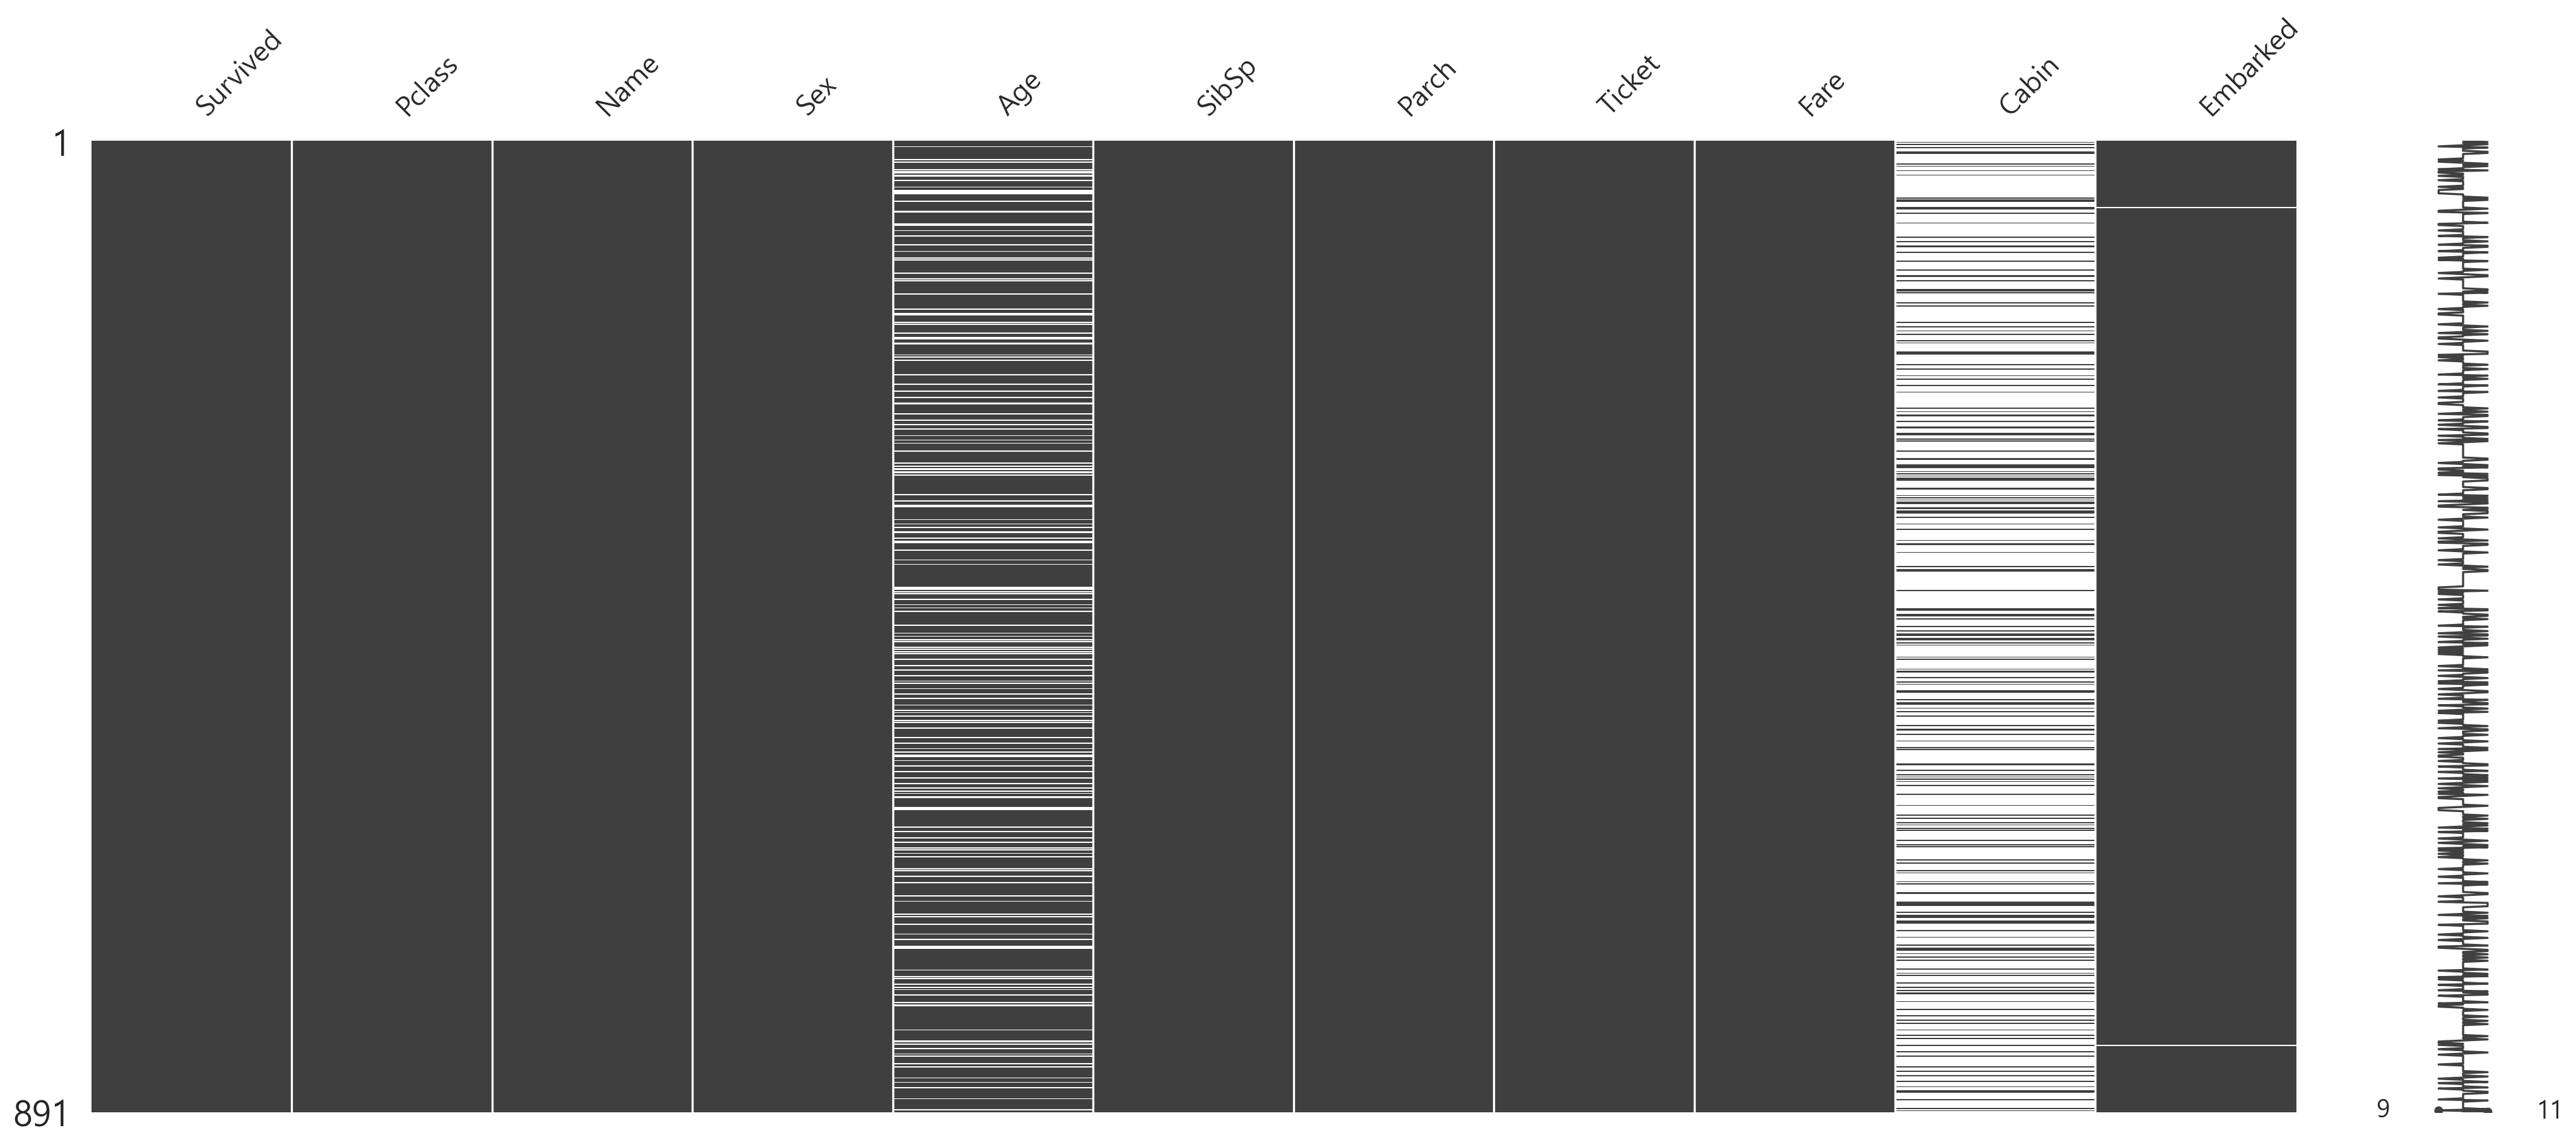

In [79]:
msno.matrix(train);

Text(0.5, 1.0, 'Pclass별 남/여 연령')

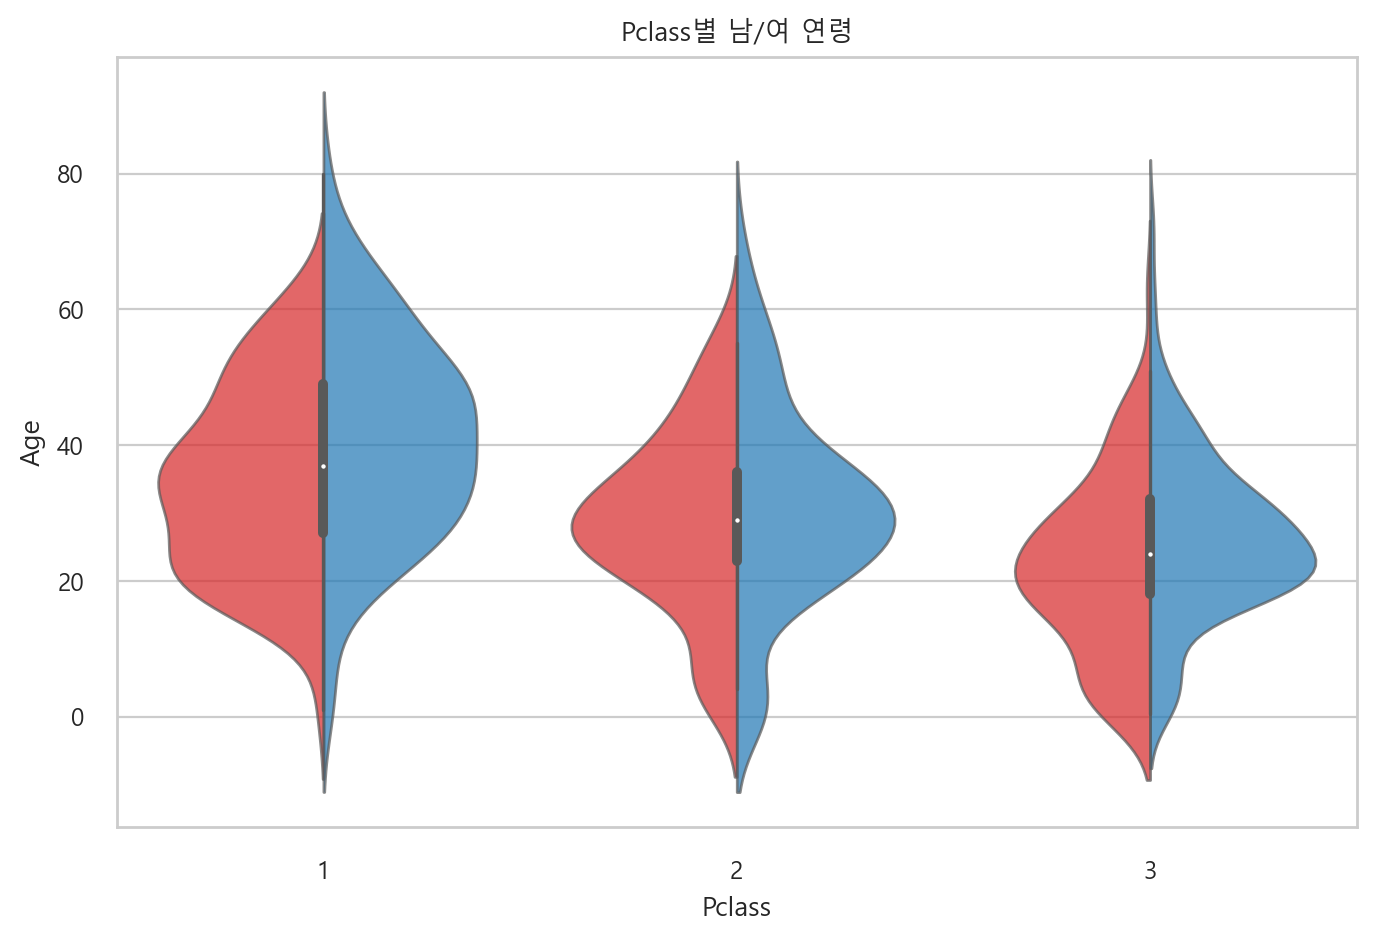

In [80]:
fig, ax = plt.subplots(figsize = (8,5))

sns.violinplot(data=train,
               x = "Pclass",
               y = "Age",
               hue="Sex",
               split=True,
               ax=ax)

for i ,obj in enumerate(ax.collections):
    if i in [0,3,6]:
        obj.set_fc("tab:red")
        obj.set_lw(1)
        obj.set_alpha(0.7)
    elif i in [2,5,8]:
        obj.set_fc("tab:blue")
        obj.set_lw(1)
        obj.set_alpha(0.7)

ax.get_legend().remove()
ax.set_title("Pclass별 남/여 연령")


In [81]:
train.groupby(["Pclass","Sex"])["Age"].agg("mean")
age_index = []
age_value = []
for c in [1,2,3]:
    for s in ["female","male"]:
        age = train[(train["Pclass"] == c) & (train["Sex"] == s)]["Age"].mean()
        age_fill = train[(train["Pclass"] == c) & (train["Sex"] == s)]["Age"].fillna(age)
        age_index.append(age_fill.keys().to_numpy())
        age_value.append(age_fill.values)

In [82]:
age_index_1d = list(chain.from_iterable(age_index))
age_value_1d = list(chain.from_iterable(age_value))

In [83]:
df_age = pd.DataFrame(data=age_value_1d, index=age_index_1d, columns=["new_age"])

In [84]:
test_new_age = pd.merge(test, df_age, left_index=True, right_index=True)

In [85]:
test_new_age["Fare"].fillna(train["Fare"].mean(), inplace=True)

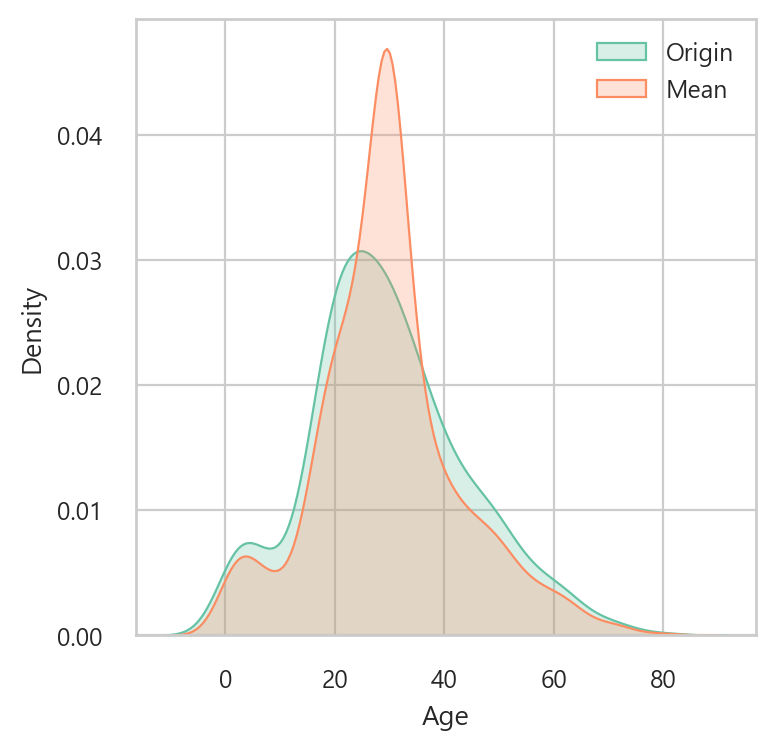

In [86]:
train_copy = train.copy()
train_copy["Age"].fillna(train["Age"].mean(), inplace=True)


fig, ax = plt.subplots(figsize = (4,4))
sns.kdeplot(train["Age"],
            fill=True,
            label="Origin")

sns.kdeplot(train_copy["Age"],
            fill=True,
            label="Mean")

sns.kdeplot(test_new_age["Age"],
            fill=True,
            label="PClass, Sex")
ax.legend();

In [87]:
titan_data_train = pd.read_csv("../data/titanic_datas/train.csv", index_col=0)
titan_data_test = pd.read_csv("../data/titanic_datas/test.csv", index_col=0)
test_final = pd.read_csv("../data/titanic_datas/gender_submission.csv", index_col=0)

titan_data_test = pd.concat([titan_data_test, test_final], axis= 1)

# 서바이벌을 카테고리로 하기
titan_data_train["Survived"] = titan_data_train["Survived"].astype('category')
# 성별 카테고리화 하기
titan_data_train["sex_m"] = pd.get_dummies(titan_data_train[["Sex"]],drop_first=True)
titan_data_test["sex_m"] = pd.get_dummies(titan_data_test[["Sex"]],drop_first=True)
titan_data_train = titan_data_train.drop(columns=["Sex"])
titan_data_test = titan_data_test.drop(columns=["Sex"])

# 가족수는 합치기
titan_data_train["familiys"] = titan_data_train["SibSp"] + titan_data_train["Parch"]
titan_data_test["familiys"] = titan_data_test["SibSp"] + titan_data_test["Parch"]
# 승선위치는 중요하지 않을 것 같다
titan_data_train = titan_data_train.drop(columns=["SibSp","Parch","Embarked"])
titan_data_test = titan_data_test.drop(columns=["SibSp","Parch","Embarked"])

# 클래스와 나이별 평균 구하기
age_dict = titan_data_train.groupby(["Pclass","sex_m"]).agg("mean", numeric_only=True)["Age"].to_dict()
age_dict

# 나이별 성별별 클래스의 평균을 내어 각각 입력한다.
for i in range(1,4):
    for j in range(0,2):
        mask_train = (titan_data_train["Pclass"] == i) & (titan_data_train["sex_m"]) == j
        mask_test = (titan_data_test["Pclass"] == i) & (titan_data_test["sex_m"]) == j
        titan_data_train.loc[mask_train,"Age"] = titan_data_train.loc[mask_train, "Age"].fillna(age_dict[(i, j)])
        titan_data_test.loc[mask_test,"Age"] = titan_data_test.loc[mask_test, "Age"].fillna(age_dict[(i, j)])

final_cols = ["Pclass","Age","Fare","sex_m","familiys"]

X = titan_data_train[final_cols].copy()  # 원본 데이터를 보호하기 위해 .copy() 사용

minmax = MinMaxScaler()
X.loc[:, ["Age", "Fare"]] = minmax.fit_transform(X.loc[:, ["Age", "Fare"]])
# X.loc[:, ["Age"]] = minmax.fit_transform(X.loc[:, ["Age"]])
y = titan_data_train["Survived"]

test_ = pd.concat([titan_data_test[final_cols], titan_data_test["Survived"]], axis=1).dropna(axis=0)
test_.loc[:, ["Age", "Fare"]] = minmax.fit_transform(test_.loc[:, ["Age", "Fare"]])
x_test = test_[final_cols]
y_test = test_["Survived"]

In [88]:
#train test

x_train = np.array(X, dtype=float)
y_train = np.array(y, dtype=float)
x_test = np.array(x_test, dtype=float)
y_test = np.array(y_test, dtype=float)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (891, 5)
y_train:  (891,)
x_test:  (417, 5)
y_test:  (417,)


In [89]:
#DT
dt=DecisionTreeClassifier(max_depth=4, splitter="best")
dt.fit(x_train,y_train)
#knn
knn = KNeighborsClassifier(n_neighbors= 4)
knn.fit(x_train,y_train)
#RFC
rfc=RandomForestClassifier(n_estimators=20,oob_score=True,max_depth=2)
rfc.fit(x_train,y_train)
#XGBOOST
xgb = XGBClassifier(n_estimators= 90, max_depth = 2, learning_rate = 0.46500000000000036)
xgb.fit(x_train,y_train);

In [90]:
# AUC-ROC Curve
tpr = [1]
fpr = [1]

for thr in np.arange(0, 1.01, 0.01): 
    pred_thr = xgb.predict_proba(x_test)[:,1]>thr


    tn = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 0)])
    fp = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 1)])
    fn = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 0)])
    tp = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 1)])

    tpr.append(tp/(fn+tp))
    fpr.append(fp/(tn+fp)) # 1 - TNR

In [91]:
tree_fpr, tree_tpr, tree_thr = roc_curve(y_test, dt.predict_proba(x_test)[:,1])
rfc_fpr, rfc_tpr, rfc_thr = roc_curve(y_test, rfc.predict_proba(x_test)[:,1])
knn_fpr, knn_tpr, knn_thr = roc_curve(y_test, knn.predict_proba(x_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thr = roc_curve(y_test, xgb.predict_proba(x_test)[:,1])

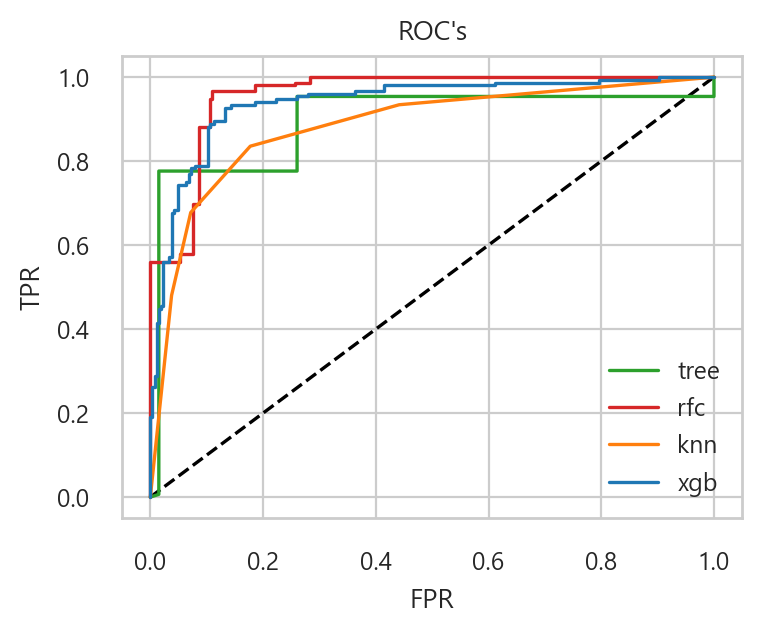

In [92]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0,1],[0,1],"k--")
ax.plot(tree_fpr, tree_tpr, label="tree", color = "tab:green")
ax.plot(rfc_fpr, rfc_tpr, label="rfc", color = "tab:red")
ax.plot(knn_fpr, knn_tpr, label="knn", color = "tab:orange")
ax.plot(xgb_fpr, xgb_tpr, label="xgb", color = "tab:blue")
ax.set(xlabel="FPR", ylabel="TPR", title="ROC's")
ax.legend();

In [95]:
# 면적
print("tree 면적",roc_auc_score(y_test, dt.predict_proba(x_test)[:,1]))
print("rfc 면적",roc_auc_score(y_test, rfc.predict_proba(x_test)[:,1]))
print("knn 면적",roc_auc_score(y_test, knn.predict_proba(x_test)[:,1]))
print("xgb 면적",roc_auc_score(y_test, xgb.predict_proba(x_test)[:,1]))

tree 면적 0.8960278053624628
rfc 면적 0.9570754716981132
knn 면적 0.8825223435948362
xgb 면적 0.9389026812313803
